# Dimensionality reduction on mouse features

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import trial_relative_frequency
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Get data

In [2]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [38]:
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_clusters = pd.read_parquet(filename, engine='pyarrow')

# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-11-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

### Frequency of trial types per mouse

In [40]:
vars = ['mouse_name', 'cluster']
vars = ['session', 'cluster']
count, freq_df = trial_relative_frequency(trial_clusters, vars)

## Prepare design matrix

In [29]:
var_names = freq_df.keys()

ori_X = np.array(freq_df[var_names]) #.values

print(np.shape(ori_X))

(215, 7)


## UMAP

In [32]:
repeats = 50
components = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
# components = np.array([1, 2, 4, 6, 8])

### Test for different random seeds

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

Text(0, 0.5, 'Negative log likelihood (SEM)')

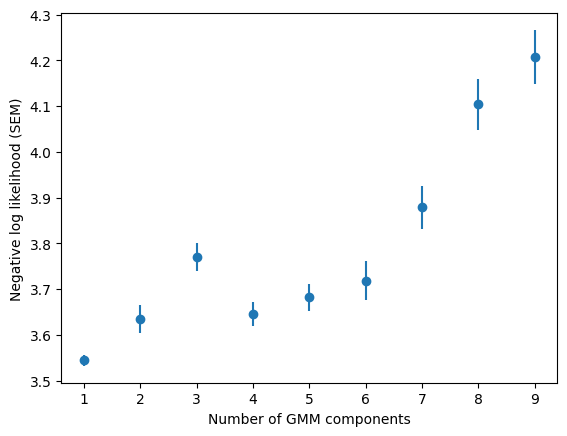

In [33]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration
    # reducer = umap.UMAP(random_state= 42, n_components=2)

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_X = scaler.fit_transform(ori_X)

    # embedding = reducer.fit_transform(standardized_X)
    # embedding.shape

    mouse_embedding = reducer.fit_transform(ori_X)
    mouse_embedding.shape
    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")


### Test for different min_dist 

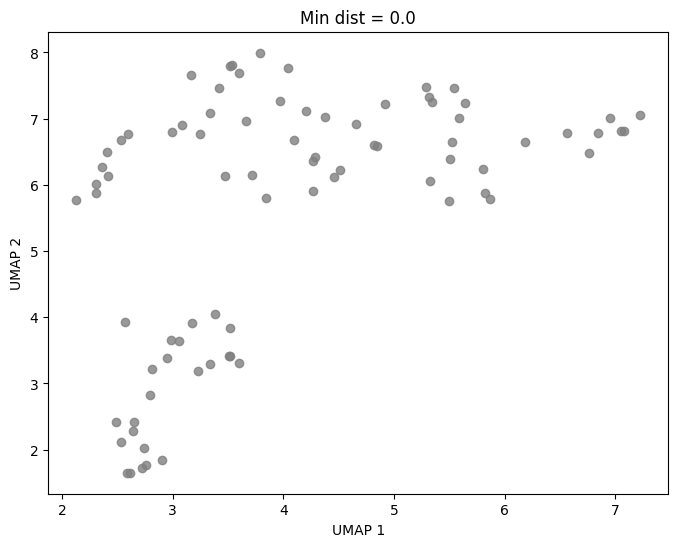

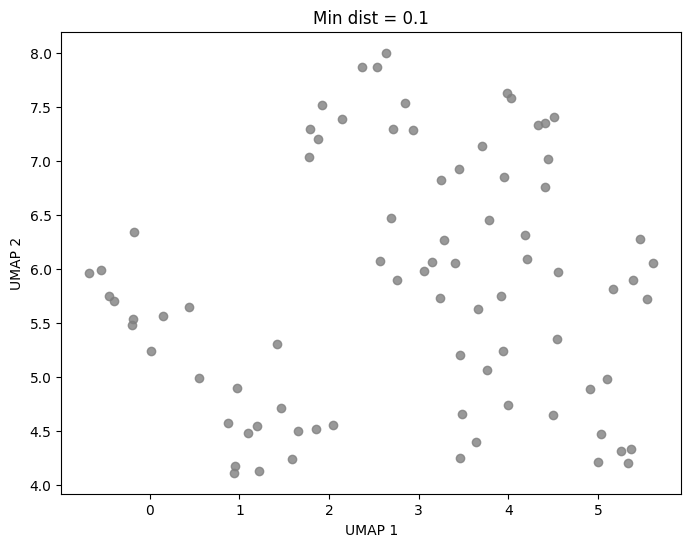

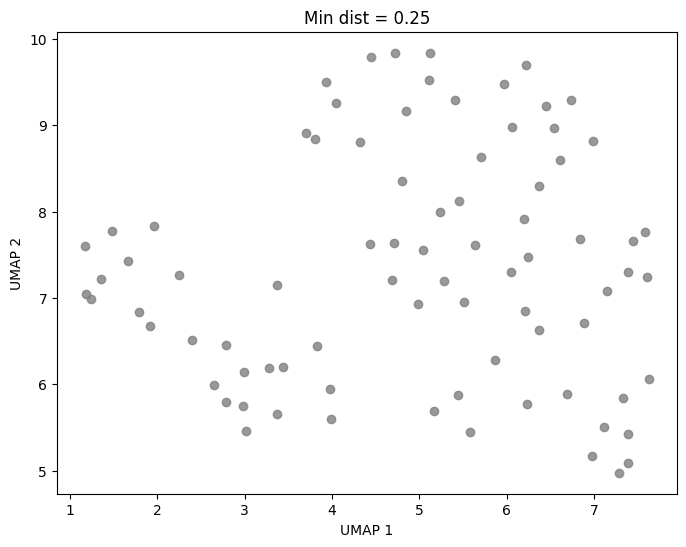

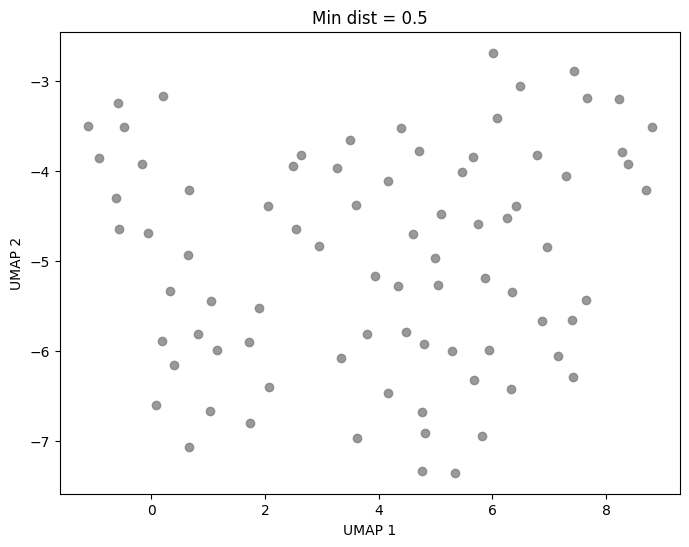

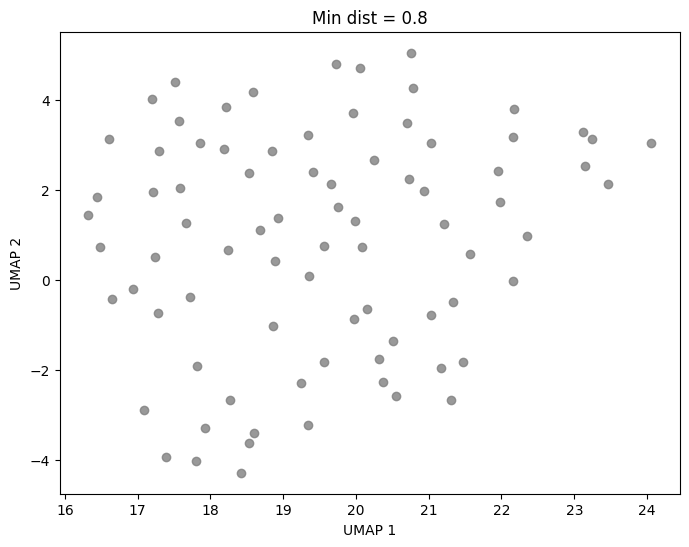

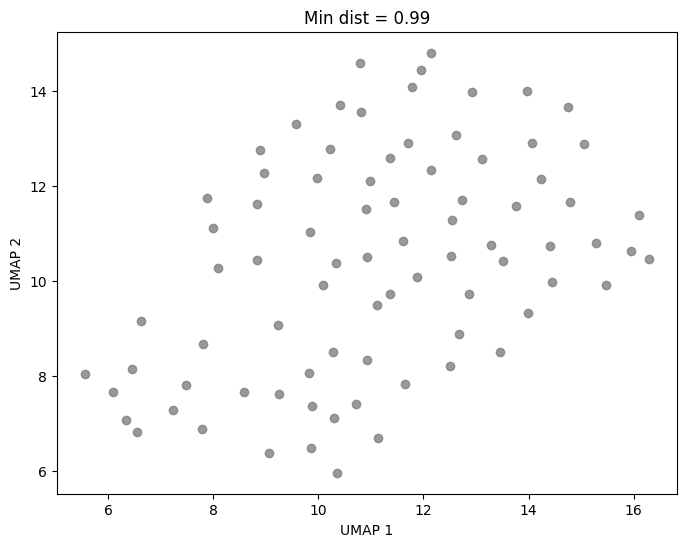

Text(0, 0.5, 'Minimum distance')

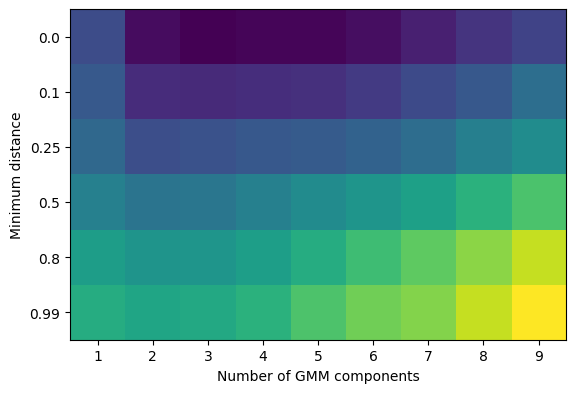

In [105]:
min_dists = np.array([0.0, 0.1, 0.25, 0.5, 0.8, 0.99]) 
LL_min_dist = np.zeros((len(min_dists), len(components))) * np.nan

for d, min_dist in enumerate(min_dists):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, min_dist=min_dist)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('Min dist = '+str(min_dist)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_min_dist[d, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_min_dist)
plt.yticks([0, 1, 2, 3, 4, 5], min_dists)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Minimum distance')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

### Test for different n_neighbours

In [67]:

n_neighbours = np.array([2, 5, 10, 20]) 
LL_neighbours = np.zeros((len(n_neighbours), len(components))) * np.nan

for n, n_neighbour in enumerate(n_neighbours):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbour)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('N neighbour = '+str(n_neighbour)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_neighbours[n, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_neighbours)
plt.yticks([0, 1, 2, 3], n_neighbours)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('N neighbors')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [34]:
for d, dist in enumerate(min_dists):
    plt.plot(components, LL_min_dist[d, :], label=dist)
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Mean Negative log likelihood')
plt.title('Minimum distance')
plt.show()

for n, neighbor in enumerate(n_neighbours):
    plt.plot(components, LL_neighbours[n, :], label=neighbor)
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Mean Negative log likelihood')
plt.title('N neighbours')
    

NameError: name 'min_dists' is not defined

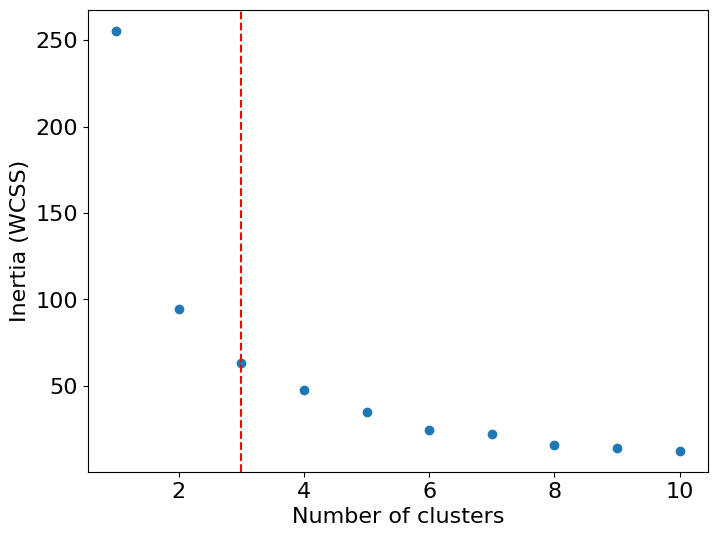

In [30]:
from kneed import KneeLocator
# Assuming `X` is your data
inertia_values = []
K = range(1, 11)
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 6))
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(mouse_embedding)[0]*0.8)
    X_train = np.vstack([mouse_embedding[:cutoff, 0], mouse_embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
# plt.title('Elbow Method for Optimal k  - mice')
plt.savefig(file_path+'inertia_mice.svg', format="svg")

plt.show()

## Run UMAP with fixed random seed

In [31]:
reducer = umap.UMAP(random_state= 42, n_components=2)

# Standardization using StandardScaler
# scaler = StandardScaler()
# standardized_X = scaler.fit_transform(ori_X)

mouse_embedding = reducer.fit_transform(ori_X)
mouse_embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(215, 2)

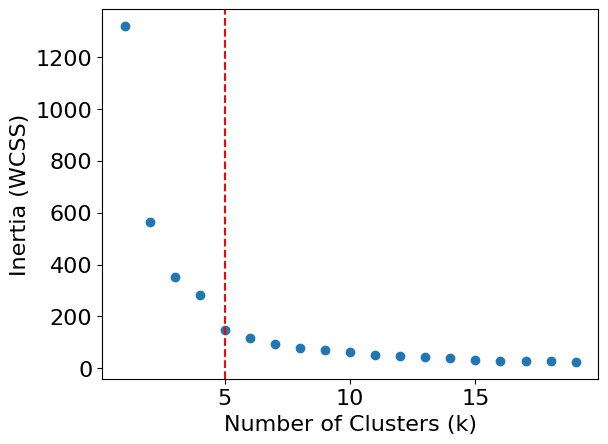

In [32]:
from kneed import KneeLocator
# Assuming `X` is your data
inertia_values = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(mouse_embedding)[0]*0.8)
    X_train = np.vstack([mouse_embedding[:cutoff, 0], mouse_embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.show()

## K-means clustering of data

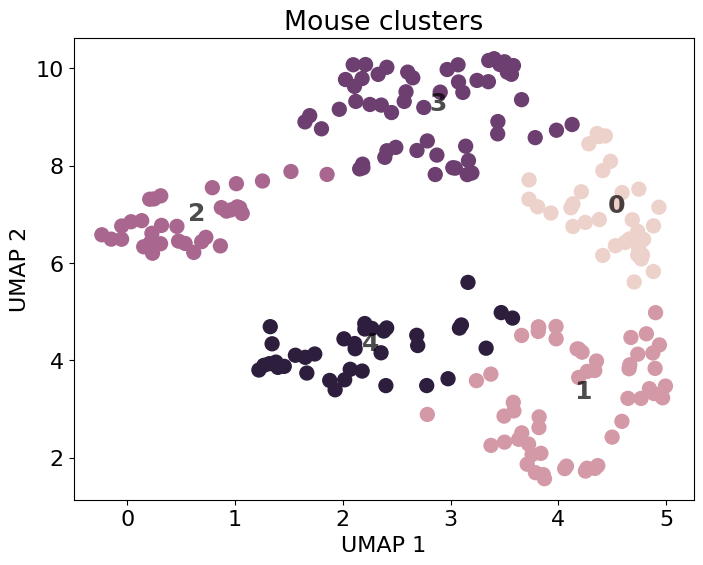

In [111]:
# Step 2: Perform KMeans Clustering
data_2d = mouse_embedding
kmeans = KMeans(n_clusters=5, random_state=2024)
kmeans.fit(data_2d)
mouse_y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=mouse_y_kmeans, s=100, alpha=1, cmap=sns.cubehelix_palette(as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


centroids = kmeans.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')

plt.title("Mouse clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

## Save mouse clusters data

In [102]:
save_df = freq_df.copy()

save_df['UMAP1'] = mouse_embedding[:, 0]
save_df['UMAP2'] = mouse_embedding[:, 1]

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(save_df.reset_index()['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(save_df.reset_index()['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = save_df.reset_index()['mouse_name'].map(map_mouse_names)

save_df['mouse_cluster'] = mouse_y_kmeans
mouse_clustered_info = count.reset_index()
mouse_clustered_info = mouse_clustered_info.merge(save_df.reset_index()[['mouse_name', 'mouse_cluster', 'UMAP1', 'UMAP2']], on='mouse_name')

KeyError: 'mouse_name'

In [23]:
file_to_save = mouse_clustered_info.copy()
filename = "cluster_per_mouse_no_timing5"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = 'H_clustering_mice.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Save session cluster info

In [112]:
save_df = freq_df.copy()

save_df['UMAP1'] = mouse_embedding[:, 0]
save_df['UMAP2'] = mouse_embedding[:, 1]

# Mouse names in number for color code
unique_session_labels = np.arange(0, len(save_df.reset_index()['session'].unique()), 1)
map_session_names = dict(zip(save_df.reset_index()['session'].unique(), unique_session_labels))
session_name_numbers = save_df.reset_index()['session'].map(map_session_names)

save_df['session_cluster'] = mouse_y_kmeans
session_clustered_info = count.reset_index()
session_clustered_info = session_clustered_info.merge(save_df.reset_index()[['session', 'session_cluster', 'UMAP1', 'UMAP2']], on='session')

In [113]:
new_df = trial_clusters.merge(session_clustered_info[['session', 'session_cluster', 'UMAP1', 'UMAP2']], on=['session'])

In [114]:
from scipy.stats import entropy


cluster_entropy = pd.DataFrame(columns=['mouse_name', 'True', 'Shuffled'], index=range(len(new_df['mouse_name'].unique())))
for m, mouse in enumerate(new_df['mouse_name'].unique()):
    cluster_entropy['mouse_name'][m] = mouse
    
    mouse_sessions = new_df.loc[new_df['mouse_name']==mouse][['mouse_name', 'session', 'session_cluster']].drop_duplicates()
    if len(mouse_sessions)> 2:

        # Compute maximum possible entropy (uniform distribution)
        max_entropy = np.log2(len(prob))  # Since base=2
        
        # Count cluster label occurrences for sample i
        labels, counts = np.unique(np.array(mouse_sessions['session_cluster']), return_counts=True)
        prob = counts / counts.sum()
        ent = entropy(prob)  # Shannon entropy
        # Normalize
        # normalized_entropy = ent / max_entropy if max_entropy != 0 else 0.0
        
        shuffle = np.random.randint(np.min(new_df['session_cluster']), np.max(new_df['session_cluster']), len(mouse_sessions))
        _, shuffle_counts = np.unique(shuffle, return_counts=True)
        shuff_prob = shuffle_counts / shuffle_counts.sum()
        shuff_ent = entropy(shuff_prob)  # Shannon entropy
        # Normalize
        # normalized_shuffle_entropy = shuff_ent / max_entropy if max_entropy != 0 else 0.0
        
        cluster_entropy['True'][m] = ent
        cluster_entropy['Shuffled'][m] = shuff_ent
        
        # print(labels, counts, ent)
        
        # sns.scatterplot(x='UMAP1', y='UMAP2', hue='session_cluster', data=new_df.loc[new_df['mouse_name']==mouse])
        # plt.xlim([-.5, 5])
        # plt.ylim([1.5, 10.5])
        # plt.show()

melted_df = pd.melt(cluster_entropy, id_vars=['mouse_name'], value_vars=['True', 'Shuffled'])

/tmp/ipykernel_35622/2274151886.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cluster_entropy['mouse_name'][m] = mouse
/tmp/ipykernel_35622/2274151886.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
Yo

Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

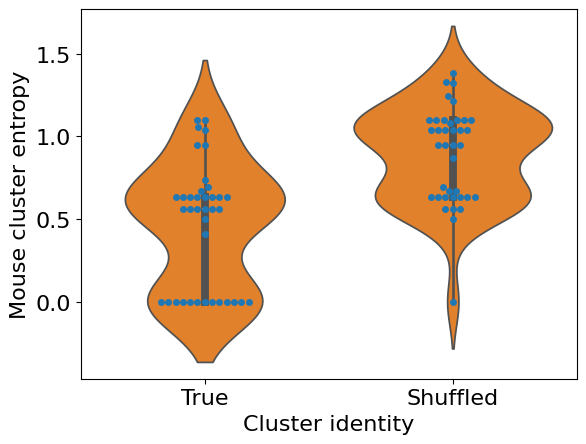

In [115]:
sns.swarmplot(x='variable', y='value', data=melted_df)
sns.violinplot(x='variable', y='value', data=melted_df)
plt.xlabel('Cluster identity')
plt.ylabel('Mouse cluster entropy')

In [77]:
len(entropies)

38

(array([ 3.,  0.,  4.,  0.,  0.,  0., 14.,  1.,  1.,  1.]),
 array([0.50040242, 0.58332832, 0.66625421, 0.7491801 , 0.83210599,
        0.91503189, 0.99795778, 1.08088367, 1.16380956, 1.24673546,
        1.32966135]),
 <BarContainer object of 10 artists>)

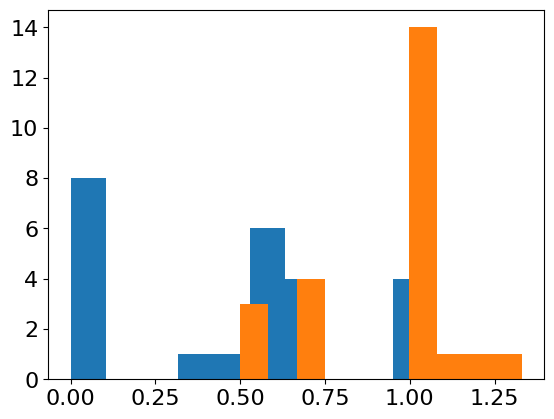

In [79]:
plt.hist(entropies)
plt.hist(shuffle_entropies)

In [100]:
file_to_save = session_clustered_info.copy()
filename = "cluster_per_session"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = 'H_clustering_mice.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)